### Extra packages that needed to be installed for this code to work outside of the OHW22 environment
pip install zarr

## Check the manual QC of ANMN against automated. 


In [1]:
from dask.distributed import Client
client = Client(n_workers=16,threads_per_worker=16) 
client

C:\Users\nribeiro\Anaconda3\lib\site-packages\distributed\node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53448 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53448/status,
Dashboard: http://127.0.0.1:53448/status,Workers: 16
Total threads: 256,Total memory: 15.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53449,Workers: 16
Dashboard: http://127.0.0.1:53448/status,Total threads: 256
Started: Just now,Total memory: 15.73 GiB
Comm: tcp://127.0.0.1:53559,Total threads: 16
Dashboard: http://127.0.0.1:53562/status,Memory: 0.98 GiB
Nanny: tcp://127.0.0.1:53460,


In [12]:
import glob
import json
import xarray as xr
import matplotlib.pyplot as plt
files = glob.glob('./reffs/IMOS_ANMN-NSW_TZ_*.json')
len(files)

687

In [3]:
def check_manual(ref):
    with open(ref, 'r') as f:
      afile = json.load(f)
    log =json.loads(afile['refs']['.zattrs'])['quality_control_log']
    return  'manually' in afile['refs']['.zattrs']

def open_dataset(ref):
    ds = xr.open_dataset(
        "reference://", engine="zarr",
        backend_kwargs={
            "storage_options": {
                "fo": ref,
                "remote_protocol": "s3",
                "remote_options": {"anon": True}
            },
            "consolidated": False
        }
    )
    return ds

In [4]:
manual_qc = list(filter(lambda x:check_manual(x), files))
len(manual_qc)

154

In [5]:
data =[ open_dataset(qc) for qc in manual_qc]

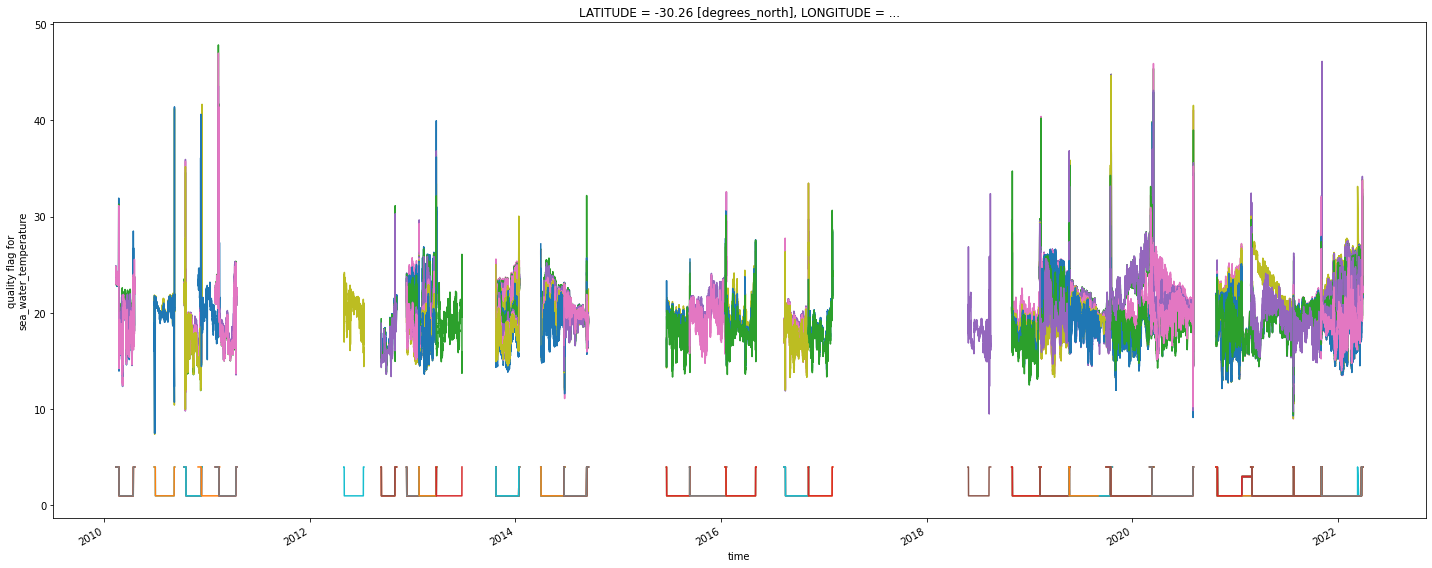

In [19]:
fig = plt.figure(figsize=(20, 8))
for d in data:
    d.TEMP.plot()
    d.TEMP_quality_control.plot()
plt.tight_layout()

In [7]:
#data
